# Main
This script demonstrates how the whole pipeline should work.

In [1]:
# Imports
import sys
sys.path.append('../..')

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from help_project.src.disease_model import data
from help_project.src.disease_model import ensemble_model
from help_project.src.disease_model.models import sir
from help_project.src.disease_model.utils import data_fetcher
from help_project.src.exitstrategies import data_elt
from help_project.src.exitstrategies import lockdown_policy
from help_project.src.economic_model.models import basic_lockdown_model as economy
from help_project.src.optimization import lockdown_config
from help_project.src.optimization import loss_function
from help_project.src.optimization import optimizer

In [2]:
# Select one country
country = 'India'

start = datetime.date(2020, 5, 11)
end = datetime.date(2020, 6, 10)

print('Working on %s between %s and %s' % (country, start, end))

Working on India between 2020-05-11 and 2020-06-10


In [3]:
fetcher = data_fetcher.DataFetcher()
population_data = fetcher.get_population_data(country)
health_data = fetcher.get_health_data(country)

past_health_data = health_data[:start - datetime.timedelta(1)]
future_health_data = health_data[start:]

In [4]:
# Get all distinct policies used by any country at any point
policy_timeseries_by_country = data_elt.DataELT.extract_attribute_data()
all_policies = list(set(
    policy_application.policy
    for policy_timeseries in policy_timeseries_by_country.values()
    for policy_application in policy_timeseries.policies
))

len(all_policies)

5

In [5]:
# Generate lockdown config - which chooses one of the precomputed policies
def generate_lockdown_policy(kwargs):
    policy = all_policies[kwargs['policy']]
    return lockdown_policy.LockdownTimeSeries([
        lockdown_policy.LockdownPolicyApplication(
            policy=policy,
            start=start,
            end=end + datetime.timedelta(1))
    ])

lockdown_config.LockdownConfig.generate_lockdown_policy = generate_lockdown_policy
config = lockdown_config.LockdownConfig(
    policy=lockdown_config.Options([i for i, _ in enumerate(all_policies)]),
)

In [6]:
# Define health & econ model wrappers and the loss function
class HealthModelWrapper:
    def __init__(self, model, population_data, health_data):
        self.model = model
        self.population_data = population_data
        self.health_data = health_data

    def run(self, policy):
        policy_data = data.PolicyData(lockdown=policy)
        out = self.model.predict(self.population_data,
                                 self.health_data,
                                 policy_data)
        index = pd.date_range(policy.policies[0].start,
                              policy.policies[-1].end - datetime.timedelta(days=1))
        out.confirmed_cases = pd.Series(data=out.confirmed_cases, index=index)
        out.recovered = pd.Series(data=out.recovered, index=index)
        out.deaths = pd.Series(data=out.deaths, index=index)
        return out


class EconomicModelWrapper:
    def __init__(self, model):
        self.model = model
    
    def run(self, policy):
        policy = policy.policies[0].policy
        return self.model.get_economic_vector(policy)


class Loss(loss_function.LossFunction):
    def compute(self, health_output, economic_output):
        return sum(health_output.deaths), -sum(economic_output.values())

In [7]:
# Create and fit a health model
fit_days = 20

health_model = sir.SIR()
health_model.fit(population_data, past_health_data[-fit_days:], data.PolicyData(lockdown=[0] * fit_days))
wrapped_health_model = HealthModelWrapper(
    health_model, population_data, past_health_data)

# Show the computed params
health_model.params

{'beta': 0.09658143047660683,
 'gamma': 0.03333817717978098,
 'b': 0.16551303448138,
 'mu': 7.934923802998933e-05,
 'mu_i': 0.04317951052474445,
 'cfr': 0.04990249115775912}

In [8]:
# Create the economic model
economic_model = economy.EconomicLockdownModel()
wrapped_economic_model = EconomicModelWrapper(economic_model)

In [9]:
# Optimize and obtain the best result
opt = optimizer.ExhaustiveSearch(config, Loss())
result = opt.optimize(wrapped_health_model, wrapped_economic_model)

def describe_policy(policy):
    for country_key, policy_timeseries in policy_timeseries_by_country.items():
        for pol in policy_timeseries.policies:
            if pol.policy == policy:
                return 'Policy "%s" applied from %s to %s' % (country_key, pol.start, pol.end or 'now')
    return 'Not found'

for pol, loss in result:
    print('Deaths: %i, GDP: %.2f - %s' % (loss[0], -loss[1], describe_policy(pol.policies[0].policy)))
    
# If there's a pareto frontier, plot the points
if len(result) > 1:
    df = pd.DataFrame([{'health': loss[0], 'economy': -loss[1]}
                   for _, (point, loss) in enumerate(result)])

    _ = sns.pointplot(x='health', y='economy', data=df)

Deaths: 224233, GDP: 5141856.28 - Policy "1_ind" applied from 2020-05-18 to now


In [10]:
# Code for Health model output Visualization
def visualize(title, past_data, predictions, ground_truth=None):
    past_df = pd.DataFrame({'date': past_data.index.strftime('%Y-%m-%d'),
                            'past': past_data})
    future_data = {'date': predictions.index.strftime('%Y-%m-%d'),
                   'predictions': predictions}
    if ground_truth is not None:
        future_data['ground_truth'] = ground_truth
    future_df = pd.DataFrame(future_data)
    data = pd.concat([past_df, future_df])    
    dates = data['date']

    melt = data.melt(id_vars=['date'], 
                     var_name='data', 
                     value_name='value')
    fig, ax = plt.subplots(figsize = (12,6))
    ax = sns.pointplot(x='date', y='value', data=melt, hue='data')
    ax.set_title(title)
    ax.set_xticklabels(labels=dates, rotation=45, ha='right')
    good_tick_count = 15
    if len(dates) > good_tick_count:
        n = len(dates) // good_tick_count
        for ind, label in enumerate(ax.get_xticklabels()):
            if ind % n == 0:  # every nth label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
    return ax

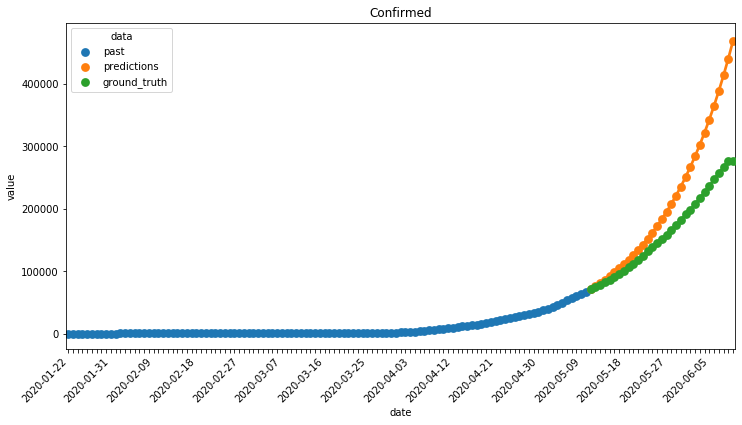

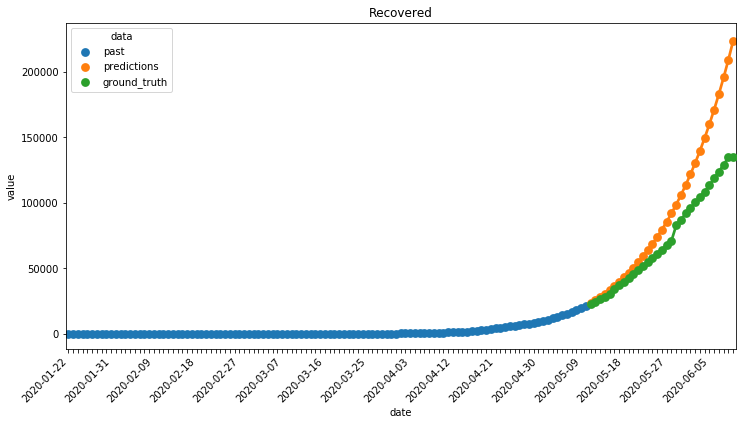

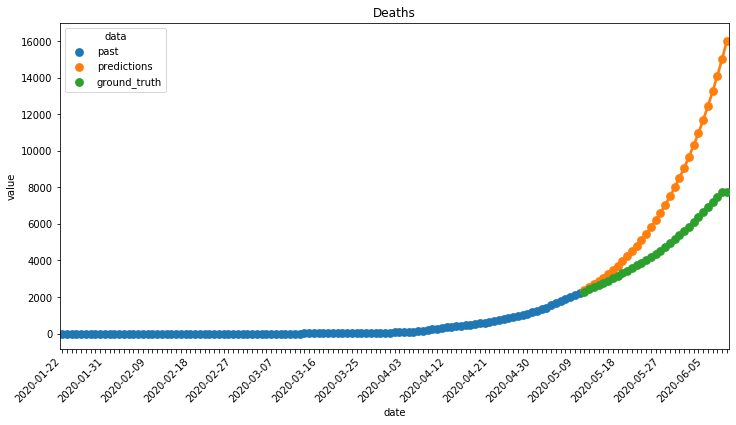

In [11]:
# Visualize policy output
policy = result[0][0]

predictions = wrapped_health_model.run(policy)

wrapped_health_model
_ = visualize('Confirmed',
              past_health_data.confirmed_cases,
              predictions.confirmed_cases,
              future_health_data.confirmed_cases)

_ = visualize('Recovered',
              past_health_data.recovered,
              predictions.recovered,
              future_health_data.recovered)

_ = visualize('Deaths',
              past_health_data.deaths,
              predictions.deaths,
              future_health_data.deaths)